# Goal

The goal of this notebook is to train a 3d UNET segmentation model to output binary mask representing the sella turcica ROI.

Notes:
- With gratitude to https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md
- TODO Augmentations: flip, orientation
- TODO Intensity normalization: N4 bias correction, hist bin matching, tissue intensity,

In [2]:
# Check GPU stats

from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)
    
# https://docs.fast.ai/dev/gpu.html
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

import torch
print("is cuda available?", torch.cuda.is_available() )
torch.cuda.empty_cache()
torch.cuda.set_device(0)

# hm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Device 0 : b'GeForce GTX 1080 Ti'
Device 1 : b'GeForce GTX 1080'
gpu: 0%, gpu-mem: 0%
is cuda available? True
cuda


In [4]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 9450MB | Used: 1728MB | Util  15% | Total 11178MB
GPU RAM Free: 7971MB | Used: 145MB | Util   2% | Total 8116MB


In [21]:
#torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  320896 KB |    7392 MB |   42581 MB |   42267 MB |
|       from large pool |  260746 KB |    7349 MB |   42457 MB |   42202 MB |
|       from small pool |   60149 KB |      61 MB |     123 MB |      65 MB |
|---------------------------------------------------------------------------|
| Active memory         |  320896 KB |    7392 MB |   42581 MB |   42267 MB |
|       from large pool |  260746 KB |    7349 MB |   42457 MB |

# Data Path

Set path to where data is stored.

In [5]:
import os

In [6]:
# Get path to 4 TB HD

# /media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home

# wsl: /home/rgologorsky/DeepPit
hd_path = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a" + "/home/rachel/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

print(all_folders)

# labels
print(os.listdir(f"{hd_path}/samir_labels"))

['ABIDE', 'PPMI', 'ABVIB', 'samir_labels']
['50155-50212', '50373-50453', '50002-50153', '50213-50312', '50313-50372']


# Imports

In [7]:
# imports

from faimed3d.all import *
from fastai import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk
import meshio

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

from helpers_preprocess import get_data_dict, paths2objs, folder2objs, seg2mask

from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

# imports
from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_viz import viz_axis

# Get Items

Item = (path to MR, path to Segmentation obj)

In [8]:
# get items = (mask_fn, nii_fn)
train_path = f"{hd_path}/samir_labels"
folders = os.listdir(train_path)

# get all items
data_dict_full = {}
for folder in folders:
    data_dict_full.update(get_data_dict(f"{train_path}/{folder}"))

items_full = list(data_dict_full.values())

# subset 300 for training/valid; 35 for test
rand_idx = torch.randperm(300)
items = np.array(items_full)[rand_idx]

print(f"Full data dict: {len(data_dict_full)} items.")
print(f"Subset data dict: {len(items)} items.")

Full data dict: 335 items.
Subset data dict: 300 items.


# Transforms

- PathToSITK (*convert paths to SITK obj*)
- Resize (*common size, isotropic spacing*)
- ToTensor (*convert to Pytorch tensor*)
- TensorSlice & Center Crop (*slice 3d tensor to center part containing sella*)
- Normalize (*scale image intensities? - diff tissues diff intensities?*)

In [9]:
class DoAll(ItemTransform):
    
    def __init__(self, new_sp = 1):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        folder  = Path(segm_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)

        mr         = sitk.ReadImage(im_path, sitk.sitkFloat32)
        segm       = meshio.read(segm_path)
        mask_arr   = seg2mask(mr, segm, ras_adj)

        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        im = torch.swapaxes(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.tensor(mask_arr).float()

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()


# Crop

In [10]:
# crop center
class CenterCropTfm(Transform):
    def __init__(self, size):
        self.size = size
        
    def encodes(self, arr):
        return self.cropND(arr, self.size)
    
    # https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    @staticmethod
    def cropND(img, bounding):
        start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
        end = tuple(map(operator.add, start, bounding))
        slices = tuple(map(slice, start, end))
        return img[slices]
    
# crop by coords
class CropBBox(Transform):
    def __init__(self, bbox):
        self.bbox = bbox
    
    def encodes(self, arr):
        imin, imax, jmin, jmax, kmin, kmax = self.bbox
        cropped = arr[imin:imax, jmin:jmax, kmin:kmax]
        
        # pad if needed
        new_size = [imax-imin, jmax-jmin, kmax-kmin]
        
        pad = [x-y for x,y in zip(new_size, arr.shape)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        return F.pad(arr, pad, mode='constant', value=0)

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [11]:
bs  = 1
general_bbox = (40, 150, 100, 320, 0, 300)

small_bbox = (50,100, 100,150, 50, 100)

In [12]:
# splits
splits = RandomSplitter(seed=42)(items)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
tfms = [DoAll(), CropBBox(small_bbox)]

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=bs, after_batch=AddChannel())

# GPU
dls = dls.cuda()

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 240, Valid: 60
<class 'tuple'> torch.Size([1, 1, 50, 50, 50]) torch.Size([1, 1, 50, 50, 50])
240 60


# Metric

Linear combination of Dice and Cross Entropy

In [13]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [14]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [15]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [16]:
# backbone = efficientnet_b0 #r3d_18 (pretrained?)
# learn    = unet_learner_3d(dls, backbone, n_out=2,  metrics = dice_score,
#                           model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')])

In [17]:
backbone = efficientnet_b0 #r3d_18 (pretrained?)
learn    = unet_learner_3d(dls, backbone, n_out=2,  metrics = dice_score)

In [18]:
# with learn.distrib_ctx():
#     learn.fit_one_cycle(1, 3e-1, wd = 1e-4)

In [23]:
# GPU
n_gpu = torch.cuda.device_count()
n_gpu

2

In [ ]:
ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx

In [19]:
# GPU
learn.model = nn.DataParallel(learn.model)
learn.model = learn.model.cuda()
#learn = learn.to_fp16()

/home/labcomputer/anaconda3/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
n_gpu = torch.cuda.device_count()
        ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx

        with partial(ctx, gpu)(): # distributed traing requires "-m fastai2.launch"
            print(f"Training in {ctx.__name__} context on GPU {gpu if gpu is not None else list(range(n_gpu))}")
            learn.fit_one_cycle(epochs)

In [20]:
# test:

#dls.device = "cpu"

start = time.time()

x,y = dls.one_batch()
#x,y = to_cpu(x), to_cpu(y)

pred = learn.model(x)
loss = learn.loss_func(pred, y)

elapsed = time.time() - start

print(f"Elapsed: {elapsed} s")
print("Batch: x,y")
print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

print("Pred shape")
print(type(pred), pred.shape, pred.dtype)

print("Loss")
print(loss)
print(learn.loss_func)

Elapsed: 2.2614049911499023 s
Batch: x,y
<class 'torch.Tensor'> torch.Size([1, 1, 50, 50, 50]) torch.float32 
 <class 'torch.Tensor'> torch.Size([1, 1, 50, 50, 50]) torch.int64
Pred shape
<class 'torch.Tensor'> torch.Size([1, 2, 50, 50, 50]) torch.float32
Loss
tensor(0.6317, device='cuda:0', grad_fn=<MeanBackward0>)


In [33]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7989 MB |    8562 MB |   39077 MB |   31087 MB |
|       from large pool |    7939 MB |    8531 MB |   38808 MB |   30868 MB |
|       from small pool |      50 MB |      57 MB |     269 MB |     218 MB |
|---------------------------------------------------------------------------|
| Active memory         |    7989 MB |    8562 MB |   39077 MB |   31087 MB |
|       from large pool |    7939 MB |    8531 MB |   38808 MB |

# LR Finder

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.2089296132326126)

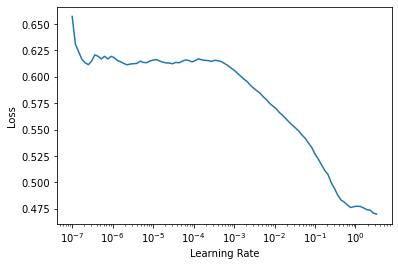

In [236]:
#learn.lr_find()

In [22]:
print("PRE learn.fit one cycle")
learn.fit_one_cycle(1, 3e-1, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

In [ ]:
print("unfreeze, learn 50")
learn.unfreeze()
learn.fit_one_cycle(50, 3e-3, wd = 1e-4)

unfreeze, learn 50


epoch,train_loss,valid_loss,dice_score,time
0,0.310232,0.328858,0.349853,00:35
1,0.305128,0.300676,0.248583,00:35
2,0.298281,0.287270,0.341916,00:35
3,0.287488,0.266072,0.507983,00:35
4,0.271086,0.235373,0.490968,00:35
5,0.250404,0.250527,0.367101,00:35
6,0.232461,0.233408,0.497551,00:35
7,0.214318,0.204818,0.551471,00:35
8,0.197701,0.183061,0.597465,00:35
9,0.179871,0.158521,0.637779,00:35


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

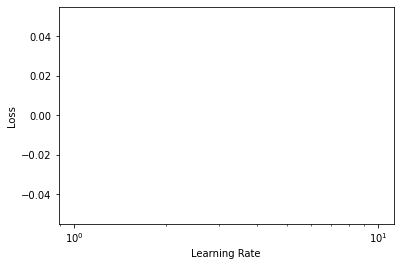

In [72]:
learn.lr_find()

In [ ]:
print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [137]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [138]:
# testmaskN = np.array(testmask)
# testmaskN

In [139]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [140]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [141]:
# maskT.shape, maskN.shape

In [142]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [143]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1